[*********************100%***********************]  1 of 1 completed


Data shape: (3269, 11)
Date range: 2011-01-04 00:00:00 to 2023-12-29 00:00:00
Columns: ['Open', 'High', 'Low', 'Close', 'Angle_1x1_Dist', 'Angle_1x1_Above', 'Angle_2x1_Dist', 'Angle_2x1_Above', 'Angle_1x2_Dist', 'Angle_1x2_Above', 'Returns']

--- Period 1 ---
Train: 2011-01-04 00:00:00 → 2011-07-05 00:00:00
Test: 2011-07-06 00:00:00 → 2011-08-03 00:00:00
Episode 0/50, Reward:0.0366, Epsilon:0.995
Episode 10/50, Reward:-0.0004, Epsilon:0.946
Episode 20/50, Reward:0.0061, Epsilon:0.900
Episode 30/50, Reward:0.1269, Epsilon:0.856
Episode 40/50, Reward:0.2072, Epsilon:0.814
Test profit: -0.0052, Trades: 3

--- Period 2 ---
Train: 2011-02-03 00:00:00 → 2011-08-03 00:00:00
Test: 2011-08-04 00:00:00 → 2011-09-01 00:00:00
Episode 0/50, Reward:-0.1027, Epsilon:0.995
Episode 10/50, Reward:0.0793, Epsilon:0.946
Episode 20/50, Reward:-0.0501, Epsilon:0.900
Episode 30/50, Reward:0.3621, Epsilon:0.856
Episode 40/50, Reward:0.1174, Epsilon:0.814
Test profit: 0.0449, Trades: 2

--- Period 3 ---
Train:

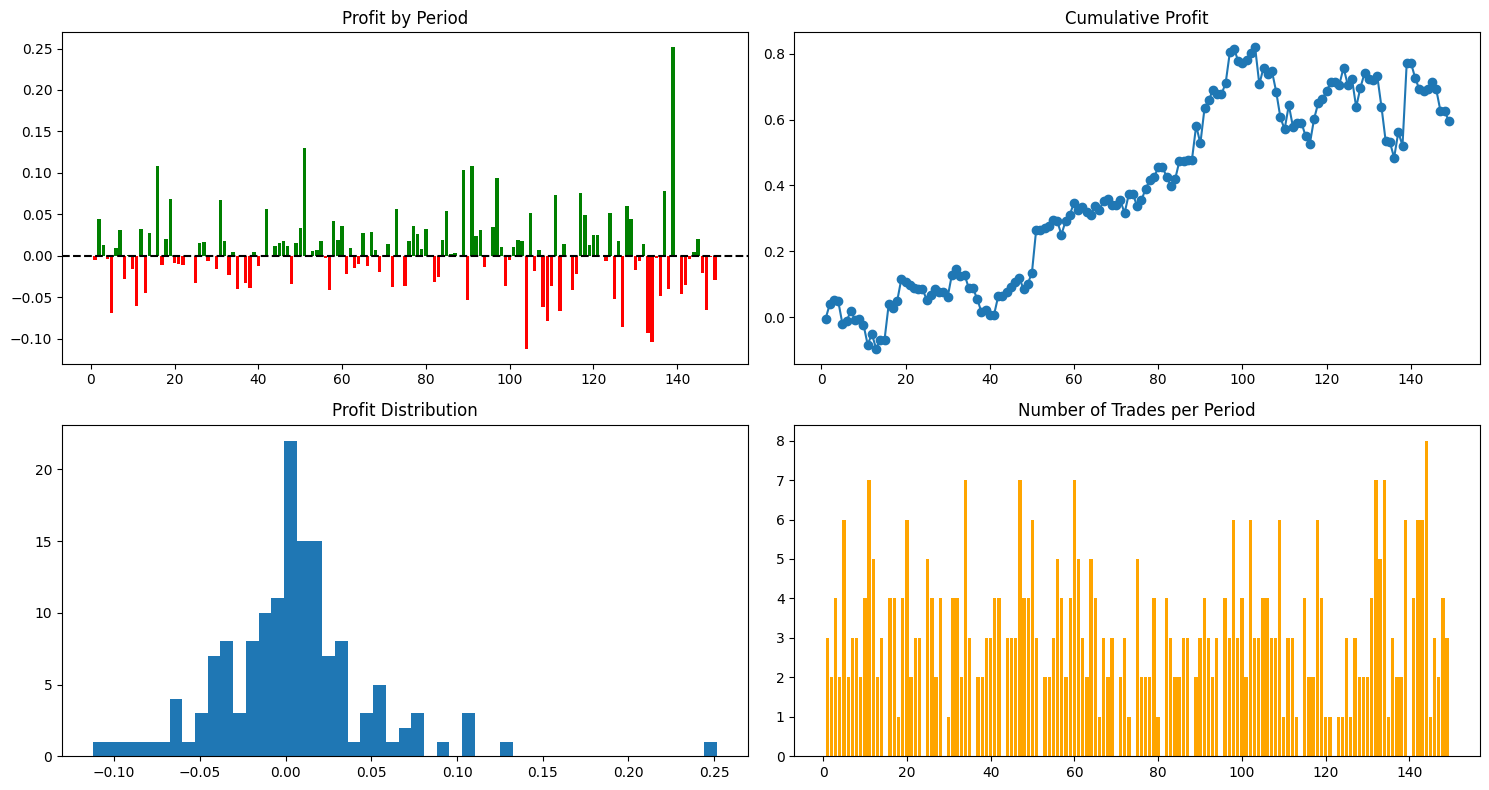

In [ ]:
# -----------------------------
# Deep Q-Learning Trading Agent
# OHLC + Pivot-Based Gann Angle Features (Consistent Version)
# -----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------
# Config
# -----------------------------
TICKER = "GOOG"
START_DATE = "2011-01-01"
END_DATE = "2023-12-31"
STATE_WINDOW = 10
SWING_WINDOW = 15
TRAIN_MONTHS = 6
TEST_MONTHS = 1
EPISODES = 50
BATCH_SIZE = 32
LR = 0.001
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# -----------------------------
# Swing Detection
# -----------------------------
def find_swing_points(df, window):
    swing_highs, swing_lows = [], []
    for i in range(window, len(df)-window):
        high = df['High'].iloc[i]
        low = df['Low'].iloc[i]
        if high == df['High'].iloc[i-window:i+window+1].max():
            swing_highs.append((df.index[i], high))
        if low == df['Low'].iloc[i-window:i+window+1].min():
            swing_lows.append((df.index[i], low))
    return swing_highs, swing_lows

# -----------------------------
# Pivot-Based Gann Angles
# -----------------------------
def assign_gann_angle_features(df, swing_highs, swing_lows):
    df = df.copy()
    angles = {"1x1": 1.0, "2x1": 2.0, "1x2": 0.5}

    for name in angles.keys():
        df[f"Angle_{name}_Dist"] = np.nan
        df[f"Angle_{name}_Above"] = np.nan

    pivots = sorted(swing_highs + swing_lows, key=lambda x: x[0])

    for i, (date, price) in enumerate(pivots):
        direction = 1 if (date, price) in swing_lows else -1
        if i < len(pivots) - 1:
            next_date = pivots[i+1][0]
            mask = (df.index >= date) & (df.index < next_date)
        else:
            mask = (df.index >= date)

        days = np.arange(mask.sum())
        for name, slope in angles.items():
            projected_prices = price + direction * slope * days
            actual_prices = df.loc[mask, 'Close'].values
            dist = actual_prices - projected_prices
            above = (actual_prices > projected_prices).astype(int)
            df.loc[mask, f"Angle_{name}_Dist"] = dist
            df.loc[mask, f"Angle_{name}_Above"] = above

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

# -----------------------------
# Download Data & Preprocess
# -----------------------------
print("Downloading data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]
df = df[['Open', 'High', 'Low', 'Close']].copy()
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)

swing_highs, swing_lows = find_swing_points(df, SWING_WINDOW)
df = assign_gann_angle_features(df, swing_highs, swing_lows)
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print("Columns:", df.columns.tolist())

# -----------------------------
# Trading Environment
# -----------------------------
class TradingEnv:
    def __init__(self, data, window=STATE_WINDOW):
        self.data = data
        self.window = window
        self.reset()

    def reset(self):
        self.current_step = self.window
        self.position = 0
        self.entry_price = 0
        self.total_profit = 0
        self.trades = []
        return self._get_state()

    def _get_state(self):
        if self.current_step >= len(self.data):
            return np.zeros(self.window * 10 + 1)
        features = self.data[['Open','High','Low','Close',
                               'Angle_1x1_Dist','Angle_1x1_Above',
                               'Angle_2x1_Dist','Angle_2x1_Above',
                               'Angle_1x2_Dist','Angle_1x2_Above']] \
                    .iloc[self.current_step - self.window:self.current_step].values
        norm = (features - np.mean(features, axis=0)) / (np.std(features, axis=0)+1e-8)
        state = norm.flatten()
        return np.append(state, self.position)

    def step(self, action):
        if self.current_step >= len(self.data):
            return self._get_state(), 0.0, True
        reward = 0.0
        current_price = self.data.iloc[self.current_step]['Close']
        transaction_cost = 0.001
        if action == 1:
            if self.position == 0:
                self.position = 1; self.entry_price = current_price; reward = -transaction_cost
            elif self.position == -1:
                profit = (self.entry_price - current_price)/self.entry_price
                reward = profit-transaction_cost; self.total_profit+=reward
                self.trades.append(('close_short', profit))
                self.position=1; self.entry_price=current_price
        elif action == 2:
            if self.position == 0:
                self.position=-1; self.entry_price=current_price; reward=-transaction_cost
            elif self.position == 1:
                profit=(current_price-self.entry_price)/self.entry_price
                reward=profit-transaction_cost; self.total_profit+=reward
                self.trades.append(('close_long', profit))
                self.position=-1; self.entry_price=current_price
        elif action == 0:
            if self.position==1:
                reward=((current_price-self.entry_price)/self.entry_price)*0.1
            elif self.position==-1:
                reward=((self.entry_price-current_price)/self.entry_price)*0.1
        self.current_step+=1
        done=self.current_step>=len(self.data)
        return self._get_state(), float(reward), done

# -----------------------------
# DQN Model
# -----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity): self.memory = deque(maxlen=capacity)
    def push(self, s,a,r,ns,d): self.memory.append((s,a,r,ns,d))
    def sample(self, batch_size): return random.sample(self.memory, batch_size)
    def __len__(self): return len(self.memory)

# -----------------------------
# Training
# -----------------------------
def train_agent(train_data):
    state_dim = STATE_WINDOW*10+1; action_dim=3
    env=TradingEnv(train_data)
    policy_net=DQN(state_dim,action_dim); target_net=DQN(state_dim,action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer=optim.Adam(policy_net.parameters(),lr=LR)
    memory=ReplayBuffer(MEMORY_SIZE)
    epsilon=EPSILON_START
    for ep in range(EPISODES):
        state=env.reset(); ep_reward=0; done=False
        while not done:
            if random.random()<epsilon:
                action=random.randrange(action_dim)
            else:
                with torch.no_grad():
                    action=torch.argmax(policy_net(torch.tensor(state,dtype=torch.float32))).item()
            next_state,reward,done=env.step(action)
            memory.push(state,action,reward,next_state,done)
            state=next_state; ep_reward+=reward
            if len(memory)>=BATCH_SIZE:
                batch=memory.sample(BATCH_SIZE)
                states,actions,rewards,next_states,dones=zip(*batch)
                states=torch.tensor(np.array(states),dtype=torch.float32)
                actions=torch.tensor(actions,dtype=torch.int64).unsqueeze(1)
                rewards=torch.tensor(rewards,dtype=torch.float32).unsqueeze(1)
                next_states=torch.tensor(np.array(next_states),dtype=torch.float32)
                dones=torch.tensor(dones,dtype=torch.float32).unsqueeze(1)
                q_vals=policy_net(states).gather(1,actions)
                next_q=target_net(next_states).max(1)[0].unsqueeze(1)
                target=rewards+(GAMMA*next_q*(1-dones))
                loss=nn.MSELoss()(q_vals,target)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        epsilon=max(EPSILON_MIN,epsilon*EPSILON_DECAY)
        if ep%TARGET_UPDATE==0: target_net.load_state_dict(policy_net.state_dict())
        if ep%10==0: print(f"Episode {ep}/{EPISODES}, Reward:{ep_reward:.4f}, Epsilon:{epsilon:.3f}")
    return policy_net

# -----------------------------
# Testing
# -----------------------------
def test_agent(test_data,model):
    env=TradingEnv(test_data); state=env.reset(); done=False
    while not done:
        with torch.no_grad():
            action=torch.argmax(model(torch.tensor(state,dtype=torch.float32))).item()
        state,_,done=env.step(action)
    return env.total_profit,len(env.trades)

# -----------------------------
# Walk-Forward
# -----------------------------
def run_walk_forward_test():
    results=[]; start_idx=0; days_per_month=21
    train_days=TRAIN_MONTHS*days_per_month; test_days=TEST_MONTHS*days_per_month; period=0
    while True:
        train_end=start_idx+train_days; test_end=train_end+test_days
        if test_end>=len(df): break
        period+=1; train_data=df.iloc[start_idx:train_end].copy(); test_data=df.iloc[train_end:test_end].copy()
        print(f"\n--- Period {period} ---")
        print(f"Train: {train_data.index[0]} → {train_data.index[-1]}")
        print(f"Test: {test_data.index[0]} → {test_data.index[-1]}")
        model=train_agent(train_data); profit,trades=test_agent(test_data,model)
        print(f"Test profit: {profit:.4f}, Trades: {trades}")
        results.append({'period':period,'profit':profit,'num_trades':trades,
                        'train_start':train_data.index[0],'train_end':train_data.index[-1],
                        'test_start':test_data.index[0],'test_end':test_data.index[-1]})
        start_idx+=test_days
    return results

# -----------------------------
# Main
# -----------------------------
if __name__=="__main__":
    results=run_walk_forward_test()
    print("\n"+"="*60); print("WALK-FORWARD TEST RESULTS (Gann Angles)"); print("="*60)
    total_profit=sum([r['profit'] for r in results]); total_trades=sum([r['num_trades'] for r in results])
    for r in results: print(f"Period {r['period']}: Profit={r['profit']:.4f}, Trades={r['num_trades']}")
    profits=[r['profit'] for r in results]
    print(f"\nSUMMARY:\nTotal periods:{len(results)}\nTotal profit:{total_profit:.4f}\n"
          f"Average profit:{np.mean(profits):.4f}\nTotal trades:{total_trades}\n"
          f"Win rate:{len([p for p in profits if p>0])/len(profits)*100:.1f}%\n"
          f"Best:{max(profits):.4f}, Worst:{min(profits):.4f}")
    # Save CSV
    pd.DataFrame(results).to_csv("gann_angle_results.csv",index=False)
    print("Results saved to gann_angle_results.csv")
    # Plots
    periods=[r['period'] for r in results]; cum_profit=np.cumsum(profits)
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1); plt.bar(periods,profits,color=['g' if p>0 else 'r' for p in profits])
    plt.title("Profit by Period"); plt.axhline(0,color='k',linestyle='--')
    plt.subplot(2,2,2); plt.plot(periods,cum_profit,marker='o'); plt.title("Cumulative Profit")
    plt.subplot(2,2,3); plt.hist(profits,bins=max(3,len(profits)//3)); plt.title("Profit Distribution")
    plt.subplot(2,2,4); plt.bar(periods,[r['num_trades'] for r in results],color='orange')
    plt.title("Number of Trades per Period")
    plt.tight_layout(); plt.savefig("gann_angle_results.png",dpi=150); plt.show()
